In [1]:
import class_database 
import pymysql
from pymysql.constants import CLIENT
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, to_tree, ClusterNode
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from sklearn.metrics.pairwise import pairwise_distances, euclidean_distances
from scipy.stats import entropy
from math import floor
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import pandas
from patsy import dmatrices
from tqdm.auto import tqdm
from pandas.tseries.offsets import MonthEnd
"""import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
r_jaccard_lib = importr("jaccard")
r_base_lib = importr('base')
r_utils_lib = importr('utils')
r_stats_lib = importr('stats')"""

'import rpy2\nimport rpy2.robjects as ro\nfrom rpy2.robjects.packages import importr\nr_jaccard_lib = importr("jaccard")\nr_base_lib = importr(\'base\')\nr_utils_lib = importr(\'utils\')\nr_stats_lib = importr(\'stats\')'

In [2]:
con = pymysql.connect(host="localhost",
                          user="PhD_alberto",
                          password="MySQL@4869",
                          autocommit=True,
                          client_flag=CLIENT.MULTI_STATEMENTS)


database = class_database.Database(con, "MSFD_ARPA_20152017_MOD1")

database.switch_to_db()

In [3]:
def make_color_map(labels : list[object], palette_name : str = "Spectral"): 
    color_labels = np.unique(labels)
    color_values = sns.color_palette(palette_name, len(color_labels))
    return dict(zip(color_labels, color_values))

def make_colors_from_labels(labels : list[object], palette_name : str = "Spectral"):     
    color_map = make_color_map(labels, palette_name)
    return list(map(lambda i : color_map[i], labels))

In [4]:
def discrete_colormap(z : list, n_colors : int = None, palette_name : str = "jet"):
    
    z_min, z_max = min(z), max(z)
    if n_colors is None: 
        n_colors = len(np.unique(z))
    cm = plt.cm.get_cmap(palette_name, n_colors)
    bounds = np.linspace(z_min, z_max, n_colors)
    norm = mpl.colors.BoundaryNorm(bounds, n_colors)
    
    return cm, bounds, norm

In [5]:
def plot_italian_coast(ax, xs : list[object] , ys : list[object], **kargs): 
    
    x_max = -np.inf
    x_min = np.inf
    y_max = -np.inf
    y_min = np.inf
    for x, y in zip(xs, ys): 
        x_max = max(x) if max(x) > x_max else x_max
        x_min = min(x) if min(x) < x_min else x_min
        y_max = max(y) if max(y) > y_max else y_max
        y_min = min(y) if min(y) < y_min else y_min
        ax.plot(x, y, 2, c = 'k', **kargs)
    ax.set_xlim(x_min * 0.99, x_max * 1.01)
    ax.set_ylim(y_min * 0.99, y_max * 1.01)

    return ax 

In [6]:
def group_and_order_abundance_species(df : pd.DataFrame, groupby_columns : list[object], taxon_column: str, numeric_column : str): 
    df = df.groupby(groupby_columns + [taxon_column]).mean()
    df = df.groupby(level = groupby_columns, group_keys=False).apply(lambda x: x.sort_values([numeric_column], ascending=False))
    return df

In [7]:
def select_threshold(group, q : float ): 
    cumsum = group.cumsum() / group.sum()
    idx = np.sum(cumsum.to_numpy() < q) + 1
    return group.iloc[:idx]

In [8]:
def find_most_representative_species(df : pd.DataFrame, groupby_columns : list[object], taxon_column : str, numeric_column : str, threshold : float = 0.9, n_greates = None, relative_abundance : bool = True): 
    df_ordered = group_and_order_abundance_species(df, groupby_columns, taxon_column, numeric_column)
    
    if relative_abundance: 
        df_ordered = df_ordered.groupby(groupby_columns, group_keys=False).apply(lambda x: x / x.sum())
        
    if n_greates: 
        if threshold: 
            raise ValueError("threshold and n_greates can not be simultaneously specified!")
        return df_ordered.groupby(groupby_columns, group_keys=False).head(n_greates)
    elif threshold: 
        return df_ordered.groupby(groupby_columns, group_keys=False).apply(select_threshold, threshold)
    else: 
        raise ValueError("Either n_greates or threshold must be set!")

In [9]:
def find_outliers(df : pd.DataFrame, column : str = None, index : str = None):
    if column: 
        df_slice = df.loc[:, column]
    elif index: 
        df_slice = df.loc[index]
    else: 
        df_slice = df
        
    Q1 = df_slice.quantile(0.25)
    Q3 = df_slice.quantile(0.75)
    IQR = Q3 - Q1
    return df_slice[~df_slice.between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR, inclusive="both")].dropna()

In [10]:
def compare_histograms(
    dfs : list[pd.DataFrame],  
    variables : list[str], 
    sup_title : str=None, 
    titles : list[str]=None,
    legend_labels : list[str]=None,
    x_labels : list[str]=None,
    y_labels : list[str]="Relative frequency",
    n_bins : int = 50,
    **kwargs
): 
    if "figsize" in kwargs: 
        figsize_dims = kwargs["figsize"]
    else: 
        figsize_dims = (8,8) if len(variables) == 1 else (8,13)
        
    if len(variables) == 1: 
        fig, axs = plt.subplots(1,1, figsize=figsize_dims)
    else : 
        n_rows = len(variables) // 2 
        fig, axs = plt.subplots(n_rows,2, figsize=figsize_dims)
        axs = axs.flat
    
    if sup_title: 
        plt.suptitle(sup_title)
        
    for ax, var, title, x_label, y_label in zip(fig.axes, variables, titles, x_labels, y_labels):
        right_edge = -np.inf
        left_edge = np.inf
        datas = [df[var].dropna().to_numpy() for df in dfs]
        for data in datas:
            right_edge = data.max() if right_edge < data.max() else right_edge
            left_edge = data.min() if left_edge > data.min() else left_edge
            
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        for data, label in zip(datas, legend_labels): 
            ax.hist(data, 
                    bins=np.linspace(left_edge,right_edge, n_bins, endpoint=True), 
                    alpha=0.5, 
                    weights=np.ones_like(data) / len(data),
                    label=label)
            ax.legend()
        
        fig.tight_layout()

In [11]:
phyto_abundances = pd.read_csv("/mnt/d/PHD/MSFD/Data/Modulo1/phyto_abund_corrected.csv",index_col=0) 

/tmp/ipykernel_3253/3270590552.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  phyto_abundances = pd.read_csv("/mnt/d/PHD/MSFD/Data/Modulo1/phyto_abund_corrected.csv",index_col=0)


In [12]:
phyto_abundances.loc[phyto_abundances["Num_cell_l"] == "<120", "Num_cell_l"] = "120" 
phyto_abundances["Num_cell_l"] = phyto_abundances["Num_cell_l"].astype(float)
phyto_abundances.rename(columns={"SampleDepth" : "Sample_depth", "Day" : "Date"}, inplace=True)
phyto_abundances["Date"] = pd.to_datetime(phyto_abundances["Date"])
phyto_abundances.drop_duplicates(inplace=True)

In [13]:
phyto_abundances_simplified = phyto_abundances.loc[phyto_abundances["Sample_depth"] == 0.5, ["Region", "id", "Longitude", "Latitude", "Date", "Sample_depth", "Taxon", "Num_cell_l"]].copy()
phyto_abundances_simplified["Genus"] = phyto_abundances_simplified["Taxon"].apply(lambda x: x.split(" ", maxsplit = 1)[0])
phyto_abundances_simplified = phyto_abundances_simplified[["Region", "id", "Longitude",	"Latitude", "Date", "Sample_depth", "Genus", "Taxon", "Num_cell_l"]]

In [14]:
df_lat_long_stations = database.extract_data("Stations", 
                                             ["id", "Latitude", "Longitude", "Closest_coast"], 
                                             join_type_table_names={"INNER" : ["Regions"]},
                                             join_type_select={"INNER" : [["Region"]]},
                                             join_type_on={"INNER" : [{"Regions.id" : "Stations.Reg_id"}]}
                                             )
phyto_points = df_lat_long_stations[["id", "Longitude", "Latitude"]].dropna().set_index("id")

In [15]:
with open("/mnt/d/PhD_coding/SQL/Italy_map_lat_long.txt", "r") as in_file:
    all_lines = in_file.readlines()
    x_pen, y_pen, x_sic, y_sic, x_sard, y_sard = list(filter(lambda x : not (x.startswith('#') or x=="\n"), all_lines))
x_pen = list(map(float, x_pen[:-1].split(' ')))
y_pen = list(map(float, y_pen[:-1].split(' ')))
x_sic = list(map(float, x_sic[:-1].split(' ')))
y_sic = list(map(float, y_sic[:-1].split(' ')))
x_sard = list(map(float, x_sard[:-1].split(' ')))
y_sard = list(map(float, y_sard[:-1].split(' ')))

In [16]:
best_path = [0,
 2,
 3,
 5,
 4,
 1,
 8,
 7,
 6,
 9,
 10,
 11,
 12,
 13,
 14,
 17,
 19,
 20,
 28,
 27,
 24,
 38,
 37,
 33,
 41,
 40,
 39,
 50,
 49,
 47,
 56,
 55,
 54,
 57,
 61,
 63,
 65,
 64,
 62,
 71,
 70,
 69,
 72,
 74,
 76,
 84,
 85,
 89,
 96,
 97,
 99,
 93,
 94,
 95,
 101,
 98,
 100,
 105,
 106,
 107,
 111,
 113,
 115,
 122,
 121,
 119,
 126,
 127,
 128,
 129,
 131,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 133,
 132,
 130,
 123,
 124,
 125,
 120,
 117,
 118,
 112,
 114,
 116,
 108,
 109,
 110,
 102,
 103,
 104,
 90,
 91,
 92,
 87,
 86,
 88,
 81,
 82,
 83,
 73,
 77,
 79,
 80,
 78,
 75,
 66,
 67,
 68,
 60,
 59,
 58,
 53,
 52,
 51,
 48,
 46,
 45,
 43,
 42,
 44,
 36,
 35,
 34,
 29,
 31,
 32,
 18,
 22,
 26,
 21,
 16,
 15,
 30,
 25,
 23]
best_path_sard = [1, 4, 5, 6, 7, 8, 12, 13, 14, 19, 16, 15, 20, 18, 17, 10, 11, 9, 0, 2, 3]

In [17]:
sea_index = {"Adriatic" : [0,45],
"Ionian" : [46, 69],
"Sicilian" : [70, 87],
"Tyrrhenian" : [88, 129],
"Ligurian" : [130,141],
"Sardinian" : [142, 161]
}
sea_index_array = np.array(list(sea_index.values()))

In [18]:
df = phyto_abundances.sort_values(by = "Latitude", ascending=False).drop_duplicates(subset = "id")[["Longitude", "Latitude", "Region", "id"]]
df.drop(df[df["Region"] == "Sardegna"].index, inplace = True)
df = df.reset_index(drop=True).reindex(best_path);
df_sard = phyto_abundances.sort_values(by = "Latitude", ascending=False).drop_duplicates(subset = "id")[["Longitude", "Latitude", "Region", "id"]]
df_sard = df_sard[df_sard["Region"] == "Sardegna"][["Longitude", "Latitude", "Region", "id"]]
df_sard = df_sard.reset_index(drop=True).reindex(best_path_sard);
df_id_ordered = pd.concat([df, df_sard], ignore_index=True)
id_ordered = df_id_ordered["id"].to_numpy()

In [19]:
ordered_regions = ["Friuli-Venezia-Giulia", 
 "Veneto", 
 "Emilia-romagna", 
 "Marche",
 "Abruzzo", 
 "Molise",
 "Puglia",
 "Basilicata",
 "Calabria", 
 "Sicilia",
 "Campania",
 "Lazio", 
 "Toscana",
 "Liguria", 
 "Sardegna",
 ]
ordered_regions_dict = {region : order for order, region in enumerate(ordered_regions)}

## Outliers

In [20]:
abund_flags = pd.DataFrame(data = {},
    columns = ["id", "Date", "Sample_depth", "Genus", "Taxon", "old_value", "new_value"]
)

In [21]:
dict_flags = {
    "id" : ["1_ABR_GU04", "M1GN6", "VAD120", "1E_MS_CH_12", "1E_MS_CH_3", "1E_MS_CH_6", "1E_MS_ES_3", "R14001_B2_6KM", "1CA02bis", "1CA03", "0129-MS00730_TR06", "0129-MS00730_TR12", "PLM1A", "SMR_CPI_WA1", "SMR_CPI_WA3", "50720"], 
    "Date" : [datetime.date(2017, 2, 16), datetime.date(2016,7,7), datetime.date(2017,4,4), 
	      datetime.date(2016,3,21), datetime.date(2016,3,21), datetime.date(2016,3,21), 
	  datetime.date(2015,12,14), datetime.date(2017,1,27), datetime.date(2017,2,17), 
      datetime.date(2017,2,17), datetime.date(2016,3,16), datetime.date(2016,3,16), datetime.date(2017,5,8), datetime.date(2016,5,18), datetime.date(2016,5,18), datetime.date(2016,5,17)],
    "Sample_depth" : [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 
    "Genus" : ["Skeletonema", "Pseudonitzschia", "Cryptophyceae", "Skeletonema", "Skeletonema", "Skeletonema", "Skeletonema", "Skeletonema", "Skeletonema", "Skeletonema", "Other", "Other", "Skeletonema", "Chaetoceros", "Chaetoceros", "Chaetoceros"], 
    "Taxon" :  ["Skeletonema costatum", "Pseudonitzschia spp. del nitzschia delicatissima", "Cryptophyceae indet.", 
		"Skeletonema costatum", "Skeletonema costatum", "Skeletonema costatum", "Skeletonema costatum", 
	"Skeletonema spp.", "Skeletonema spp.", "Skeletonema spp.", "Other phytoplankton (ø inf. 20µm)", "Other phytoplankton (ø inf. 20µm)", "Skeletonema sp.", "Chaetoceros wighamii", "Chaetoceros socialis", "Chaetoceros spp."],
    "old_value" : [2648700.0, 3576619.0, 2957453.0, 4615680.0, 6332136.0, 5449868.0, 3752000.0, 2685978.0, 6551801.0, 4383943.0, 1.531526e+06, 1.212006e+06, 1.547537e+06, 2037207.0, 1717754.0, 4195393.0], 
    "new_value" : [264870.0, 357662.0, 29575.0, 461568.0, 633214.0, 544987.0, 375200.0, 268598.0, 655180.0, 438394.0, 1.531526e+05, 1.212006e+05, 1.547537e+05, 203721.0, 171775.0, 419539.0]
}

In [22]:
phyto_abund_corrected = phyto_abundances_simplified.copy()

In [23]:
for i in range(len(dict_flags["id"])): 
    condition = (phyto_abund_corrected["id"] == dict_flags["id"][i]) & \
    (phyto_abund_corrected["Date"] == pd.to_datetime(dict_flags["Date"][i])) & \
    (phyto_abund_corrected["Taxon"] == dict_flags["Taxon"][i]) & \
    (phyto_abund_corrected["Num_cell_l"] == dict_flags["old_value"][i])
    phyto_abund_corrected.loc[condition, "Num_cell_l"] = dict_flags["new_value"][i]

In [24]:
#define query 
condition = (phyto_abundances_simplified["id"] == "1_ABR_GU04") & (phyto_abundances_simplified["Date"] == "2017-02-16")	& \
(phyto_abundances_simplified["Sample_depth"] == 0.5) & (phyto_abundances_simplified["Taxon"] == "Skeletonema costatum")

In [149]:
phyto_abund_by_Date = phyto_abund_corrected[["Region", "id", "Date", "Taxon", "Num_cell_l"]].groupby(["Region", "id","Date", "Taxon"]).mean().reset_index(
).groupby(["Region", "id", "Date"]).sum(numeric_only=True).reset_index().groupby(["Region", "id", pd.Grouper(key = "Date", freq = "M")]).mean().reset_index()
#phyto_abund_by_Date["Num_cell_l_log"] = np.log10(phyto_abund_by_Date["Num_cell_l"])

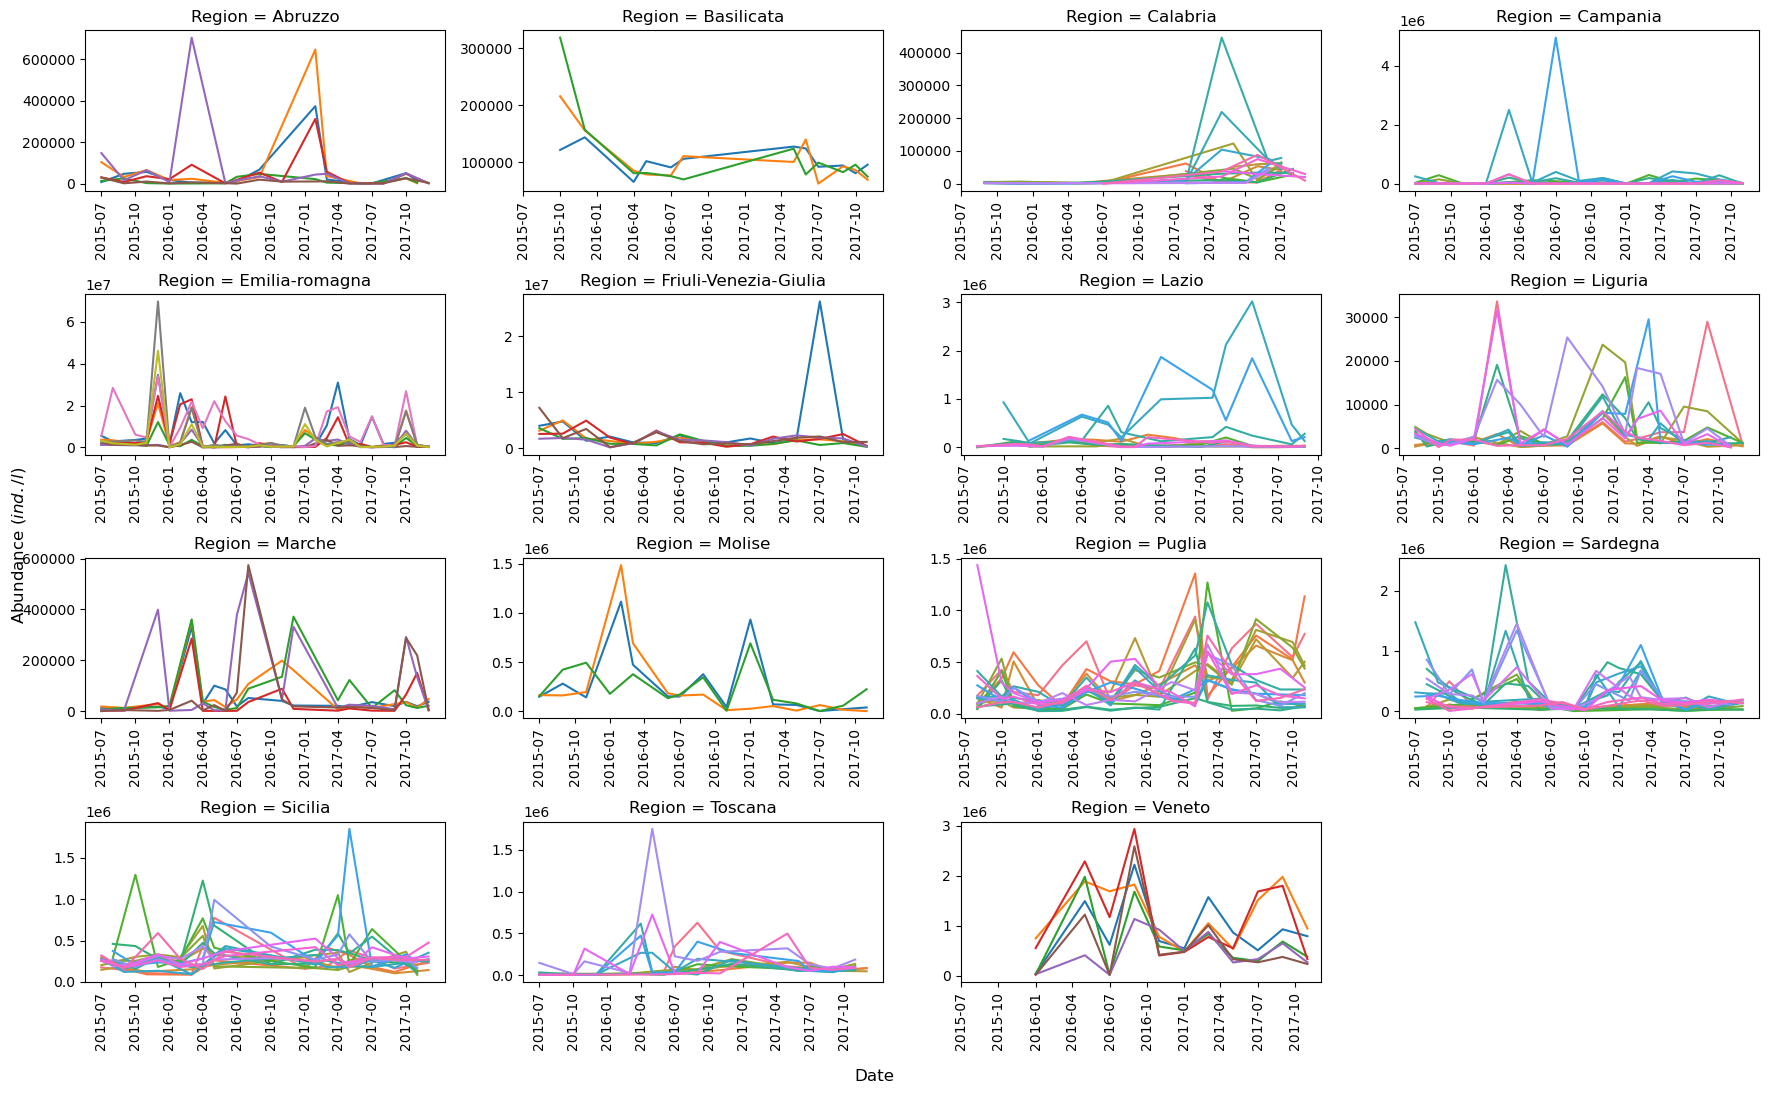

In [145]:
fig, axs = plt.subplots(4, 4, figsize=(18, 11))
axs = axs.flat
x_ticks = pd.date_range(phyto_abund_by_Date["Date"].min(), phyto_abund_by_Date["Date"].max(), freq="3M")
x_labels =  [Date.strftime("%Y-%m") for Date in x_ticks]
fig.delaxes(axs[-1])
for (group_name, group), ax in zip(phyto_abund_by_Date.groupby("Region"), axs): 
    sns.lineplot(group, x = "Date", y = "Num_cell_l", hue = "id", ax = ax, legend=False)
    ax.set_title(f"Region = {group_name}")
    ax.set_xticks(ticks = x_ticks,  labels=x_labels, rotation = 90)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
fig.supxlabel("Date")
fig.supylabel(r"Abundance ($ind. / l$)")
plt.tight_layout()

In [150]:
df = phyto_abund_by_Date.query("Region == 'Abruzzo'").copy()
df["Date"] = pd.to_datetime(df["Date"]).dt.date
df["Date"] = df["Date"] + MonthEnd(0)
df[["id", "Date", "Num_cell_l"]].pivot(index = "id", columns="Date", values="Num_cell_l")

Date,2015-07-31,2015-09-30,2015-11-30,2016-01-31,2016-03-31,2016-06-30,2016-07-31,2016-09-30,2016-11-30,2017-02-28,2017-03-31,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-10-31,2017-11-30,2017-12-31
id,,,,,,,,,,,,,,,,,,
1_ABR_GU04,7960.0,47796.0,56986.0,18240.0,4920.0,5720.0,10040.0,68240.0,NaN,373434.0,20520.0,NaN,1020.0,1880.0,NaN,50760.0,15840.0,NaN
1_ABR_GU05,103920.0,32600.0,65792.0,17720.0,23960.0,4000.0,13240.0,31920.0,NaN,645708.0,36800.0,NaN,1820.0,1440.0,NaN,26160.0,2640.0,NaN
1_ABR_GU06,13440.0,25960.0,3000.0,960.0,1240.0,1880.0,33360.0,47280.0,NaN,22236.0,5400.0,NaN,1800.0,2800.0,NaN,26800.0,5520.0,NaN
1_ABR_VA13,30600.0,8640.0,36248.0,21920.0,91360.0,1800.0,18600.0,53600.0,8520.0,311740.0,57520.0,3600.0,NaN,NaN,880.0,48720.0,NaN,2560.0
1_ABR_VA14,147480.0,17000.0,64810.0,8280.0,702992.0,3280.0,15640.0,35840.0,9800.0,44036.0,47960.0,1440.0,NaN,NaN,1120.0,50680.0,NaN,1680.0
1_ABR_VA15,29840.0,2080.0,10474.0,1640.0,6480.0,2560.0,640.0,19640.0,10240.0,10900.0,12000.0,880.0,NaN,NaN,2240.0,26160.0,NaN,3760.0


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
#x_ticks = pd.date_range(phyto_abund_by_Date.query("Region == 'Abruzzo'")["Date"].min(), phyto_abund_by_Date.query("Region == 'Abruzzo'")["Date"].max(), freq="2M")
#x_labels =  [Date.strftime("%Y-%m") for Date in x_ticks]
sns.lineplot(data = phyto_abundances_simplified.query("Region == 'Campania'").groupby(["id", "Date"]).sum(numeric_only=True), x = "Date", y = "Num_cell_l", ax = ax, hue = "id")
#ax.set_xticks(ticks = x_ticks, labels=x_labels, rotation = 90);

<AxesSubplot: xlabel='id', ylabel='Num_cell_l'>

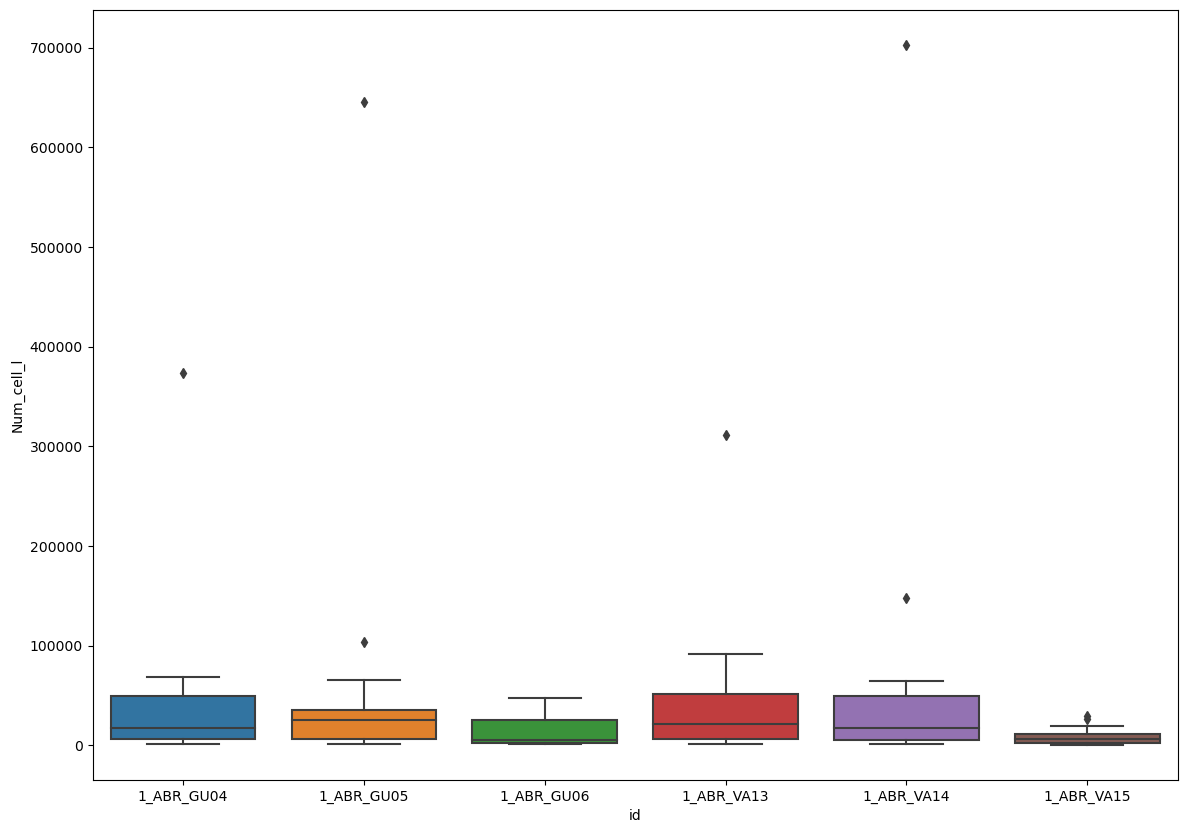

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
#x_ticks = pd.date_range(phyto_abund_by_Date.query("Region == 'Abruzzo'")["Date"].min(), phyto_abund_by_Date.query("Region == 'Abruzzo'")["Date"].max(), freq="2M")
#x_labels =  [Date.strftime("%Y-%m") for Date in x_ticks]
sns.boxplot(data = df, x = "id", y = "Num_cell_l", ax = ax, orient="v")
#ax.set_xticks(ticks = x_ticks, labels=x_labels, rotation = 90);

In [ ]:
for (region, group_reg) in df_for_outliers.groupby("Region"): 
    group_reg = group_reg.groupby(["id", "Date"]).sum(numeric_only=True).reset_index().pivot(index = "id", columns="Date", values="Num_cell_l")
    print(f"\n\t\t****{region.upper()}****")
    for id in group_reg.index: 
        print(find_outliers(group_reg, index = id))

## Abundant species

In [94]:
phyto_abund_category = phyto_abund_corrected.copy()
phyto_abund_category.loc[phyto_abund_category["Genus"] == "Other", "Det_level"] = "Unknown"
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("indet") & ~phyto_abund_category["Taxon"].str.contains("Other"), "Det_level"] = "Class"
phyto_abund_category.loc[phyto_abund_category["Taxon"].str.contains("sp.") | phyto_abund_category["Taxon"].str.contains("spp."), "Det_level"] = "Genus"
phyto_abund_category.loc[phyto_abund_category["Det_level"].isna(), "Det_level"] = "Species"
phyto_abund_by_category = phyto_abund_category[["Region", "id", "Date", "Det_level", "Num_cell_l"]].groupby(["Region", "Det_level", "id","Date"]).sum().groupby(["Region", "Det_level", "id"]).mean().groupby(["Region", "Det_level"]).sum().reset_index()
#phyto_abund_by_category = np.log10(phyto_abund_by_category[["Region", "id", "Date", "Det_level", "Num_cell_l"]].groupby(["Region", "Det_level", "id","Date"]).sum().groupby(["Region", "Det_level", "id"]).mean().groupby(["Region", "Det_level"]).sum()).reset_index()

In [2]:
labels = phyto_abund_by_category["Det_level"].unique()
colours = {label : f"C{n}" for n, label in enumerate(labels)}
fig, axs = plt.subplots(3, 5, figsize=(15, 8))
axs = axs.flat
sorting = lambda col: [ordered_regions_dict[item] for item in col.to_list()]
for i, ((group_name, group), ax) in enumerate(zip(phyto_abund_by_category.sort_values(by = "Region", key = sorting).groupby("Region", sort=False), fig.axes)): 
    ax.pie(group["Num_cell_l"].to_numpy(), labels = group["Det_level"].to_numpy(), colors= [colours[key] for key in group["Det_level"].to_numpy()], radius = rad)
    ax.set_title(group_name)
fig.suptitle("Contribution to the abundance of each phytoplankton category (all data considered)")
plt.tight_layout()
#plt.savefig("/mnt/d/PHD/NBFC_meeting_20230712/Category_contribution.pdf")

NameError: name 'phyto_abund_by_category' is not defined

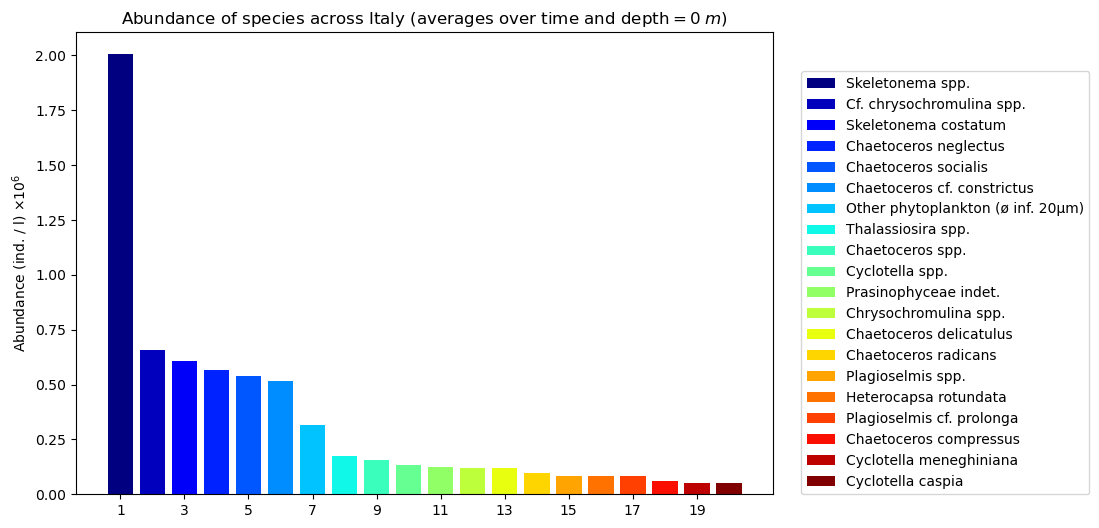

In [26]:
n_species = 20
phyto_abundances_per_species = phyto_abund_corrected[["Taxon", "Num_cell_l"]].groupby("Taxon").mean().sort_values("Num_cell_l", ascending=False).reset_index()
abundance = phyto_abundances_per_species.loc[0:n_species-1, "Num_cell_l"].copy().to_numpy()  
order_of_magnitude = floor(abs(np.log10(abundance.max())))
abundance /= 10 ** order_of_magnitude
species = phyto_abundances_per_species.loc[0:n_species-1, "Taxon"].copy().to_numpy()
cm, bounds, norm = discrete_colormap(np.arange(n_species),n_species)
fig, ax = plt.subplots(1,1, figsize=(9,6))
for i, (spec, taxon) in enumerate(zip(abundance, species)): 
    ax.bar(i + 1, height = spec, label = taxon, color = cm(i))
ax.legend(loc=(1.04, 0))
ax.set_ylabel(r"Abundance (ind. / l) $\times 10^{}$".format(order_of_magnitude))
ax.set_xlabel("")
ax.set_title("Abundance of species across Italy (averages over time and " + r"depth$ = 0 \; m$)")
ax.set_xticks([i for i in range(1, n_species, 2)]);
#plt.savefig("/mnt/d/PHD/Most_abundant_species.png")

In [97]:
phyto_points

,Longitude,Latitude
id,,
1_ABR_GU04,14.0418,42.7609
1_ABR_GU05,14.1072,42.7744
1_ABR_GU06,14.2380,42.8012
1_ABR_VA13,14.7225,42.2216
1_ABR_VA14,14.7609,42.2627
...,...,...
50720,12.4172,45.0979
60530,12.4504,45.2852
60720,12.4816,45.1220


In [99]:
def distribution_single_taxon(taxon_name : str, taxon_level : str, grouby_columns : list[str], numeric_column : str, df : pd.DataFrame, **kargs):  
    df = df[df[taxon_level] == taxon_name]
    df = df.groupby(by = grouby_columns).mean()
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    cm, bounds, norm = discrete_colormap(df[numeric_column].to_numpy(), 15);
    plot_italian_coast(ax, (x_pen, x_sic, x_sard), (y_pen, y_sic, y_sard), alpha = 0.7);
    geo_matrix = phyto_points.loc[df["id"].to_numpy(), ["Longitude", "Latitude"]].to_numpy().T
    sc = ax.scatter(*geo_matrix, c = df[numeric_column].to_numpy(), cmap = cm, norm = norm, s = 20);
   # ax.set_xlim(df["Longitude"].min() * 0.99, df["Longitude"].max() * 1.01)
    #ax.set_ylim(df["Latitude"].min() * 0.99, df["Latitude"].max() * 1.01)
    ax.set_xlabel("Longitude");
    ax.set_ylabel("Latitude");
    ax.set_title(taxon_name);
    plt.colorbar(sc, cmap=cm, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%2.2f', label = "log((# individuals) / l)");
    return ax

/tmp/ipykernel_3253/2780955391.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(by = grouby_columns).mean()


KeyError: 'id'

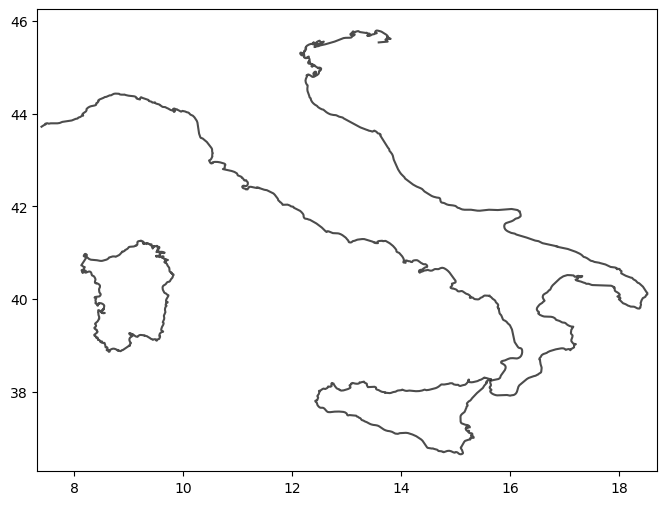

In [105]:
distribution_single_taxon("Skeletonema costatum", "Taxon", "id", "Num_cell_l", phyto_abund_corrected[["id", "Taxon", "Num_cell_l"]])

## frequent species

In [27]:
spatial_freq_species = phyto_abundances_simplified[["id", "Taxon"]].drop_duplicates().groupby("Taxon").count().sort_values("id", ascending=False).reset_index()

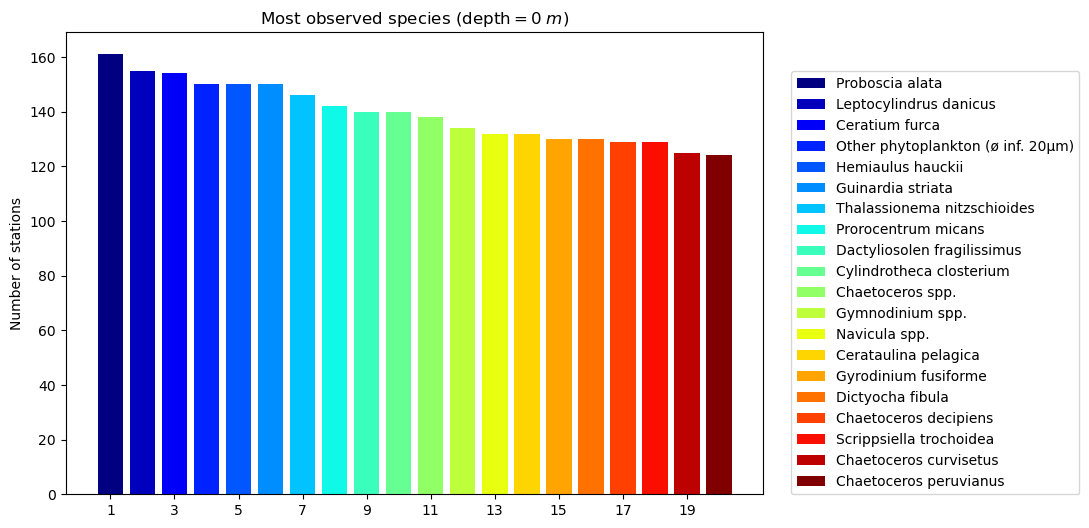

In [96]:
cm, bounds, norm = discrete_colormap(spatial_freq_species["id"].to_numpy(), 20)
fig, ax = plt.subplots(1,1, figsize=(9,6))
for i, (spec, taxon) in enumerate(zip(spatial_freq_species["id"][:20].to_numpy(), spatial_freq_species["Taxon"][:20].to_numpy())): 
    ax.bar(i + 1, height = spec, label = taxon, color = cm(i), )
ax.legend(loc=(1.04, 0))
#ax.set_ylabel(r"Abundance (ind. / l) $\times 10^{}$".format(order_of_magnitude))
ax.set_xlabel("")
ax.set_title("Most observed species " + r"(depth$ = 0 \; m$)")
ax.set_ylabel("Number of stations")
ax.set_xticks([i for i in range(1, 20, 2)]);

In [ ]:
presece_by_region = phyto_abundances_simplified[["Region", "Taxon"]].drop_duplicates()
presece_by_region["presence"] = 1
pd.DataFrame(presece_by_region.pivot(index="Taxon", columns="Region", values="presence").sum(axis = 1).sort_values(ascending=False), columns=["N_region"]);

In [ ]:
presece_by_date = phyto_abundances_simplified[["Date", "Taxon"]].copy()
presece_by_date["Date"] += MonthEnd(0)
presece_by_date["presence"] = 1
presece_by_date.drop_duplicates(inplace=True)
pd.DataFrame(presece_by_date.pivot(index="Taxon", columns="Date", values="presence").sum(axis = 1).sort_values(ascending=False), columns=["N_region"]);

In [205]:
pd.merge(pd.DataFrame(presece_by_region.pivot(index="Taxon", columns="Region", values="presence").sum(axis = 1).sort_values(ascending=False), columns=["N_region"]),
         pd.DataFrame(presece_by_date.pivot(index="Taxon", columns="Date", values="presence").sum(axis = 1).sort_values(ascending=False), columns=["N_Date"]),
         on = "Taxon").sort_values(["N_region", "N_Date"], ascending=False)[:30]

,N_region,N_Date
Taxon,,
Prorocentrum micans,15.0,30.0
Gyrodinium fusiforme,15.0,30.0
Leptocylindrus danicus,15.0,30.0
Hemiaulus hauckii,15.0,30.0
Guinardia striata,15.0,30.0
Thalassionema nitzschioides,15.0,30.0
Ceratium furca,15.0,30.0
Proboscia alata,15.0,30.0
Chaetoceros affinis,15.0,28.0


### species level 

In [89]:
species_name = "Chaetoceros socialis"	

In [90]:
ids_dates = phyto_abund_corrected.loc[phyto_abund_corrected["Taxon"] == species_name, ["Region", "id", "Date"]]

In [91]:
t1 = ids_dates.merge(phyto_abund_corrected, on = ["id", "Date"])[["id", "Date", "Taxon", "Num_cell_l"]].groupby(["id", pd.Grouper(key = "Date", freq = "M"), "Taxon"]).mean().reset_index().groupby(["id", "Date"]).sum(numeric_only=True)

In [92]:
t2 = phyto_abund_corrected.loc[phyto_abund_corrected["Taxon"] == species_name, ["Region", "id", "Date", "Num_cell_l"]].groupby(["id", pd.Grouper(key = "Date", freq = "M")]).mean(numeric_only = True)

<AxesSubplot: xlabel='Num_cell_l', ylabel='Count'>

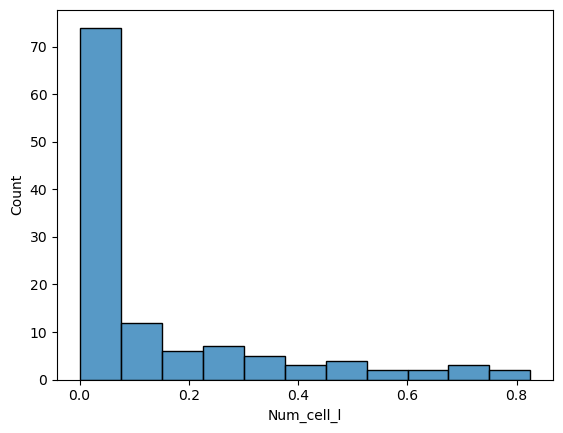

In [93]:
sns.histplot((t2 / t1).reset_index(), x = "Num_cell_l")

In [195]:
presece_by_region = phyto_abundances_simplified[["Region", "Genus"]].drop_duplicates()
presece_by_region["presence"] = 1
presece_by_region.pivot(index="Genus", columns="Region", values="presence").sum(axis = 1).sort_values(ascending=False)

Genus
Lioloma          15.0
Scrippsiella     15.0
Bacteriastrum    15.0
Prorocentrum     15.0
Nitzschia        15.0
                 ... 
Campylosira       1.0
Leptodiscus       1.0
Lebouridinium     1.0
Cerataulus        1.0
A.                1.0
Length: 311, dtype: float64

In [194]:
presece_by_date = phyto_abundances_simplified[["Date", "Genus"]].copy()
presece_by_date["Date"] += MonthEnd(0)
presece_by_date["presence"] = 1
presece_by_date.drop_duplicates(inplace=True)
presece_by_date.pivot(index="Genus", columns="Date", values="presence").sum(axis = 1).sort_values(ascending=False).iloc[:30]

Genus
Dactyliosolen        30.0
Pseudonitzschia      30.0
Cerataulina          30.0
Prorocentrum         30.0
Gonyaulax            30.0
Guinardia            30.0
Proboscia            30.0
Gymnodinium          30.0
Bacillariophyceae    30.0
Gyrodinium           30.0
Bacteriastrum        30.0
Hemiaulus            30.0
Heterocapsa          30.0
Karenia              30.0
Katodinium           30.0
Oxytoxum             30.0
Other                30.0
Chaetoceros          30.0
Leptocylindrus       30.0
Nitzschia            30.0
Navicula             30.0
Leucocryptos         30.0
Ceratium             30.0
Protoperidinium      30.0
Coccolithophyceae    30.0
Pseudosolenia        30.0
Dictyocha            30.0
Amphidinium          30.0
Cryptophyceae        30.0
Dinoflagellata       30.0
dtype: float64